<a href="https://colab.research.google.com/github/franciscojferrari/AUTOVC/blob/data-processing/DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


To do:
*   Write labels in addition to spectrogram.
*   Is it possible to write in parralel to the tfrecords file?




In [1]:
! pip install -q tensorflow-io

In [2]:
from google.colab import auth
import tensorflow_io as tfio 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm 
import os

Authenticate user:

```
auth.authenticate_user()
```

Download needed packages:

```
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
```

Mount the bucket to colab:


```
!mkdir DataSet
!gcsfuse autovc_datasets DataSet
```




# Environment setting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/My Drive/KTH/DT2119/autovc/auth.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS

project='dt2119-autovc' # change to your project name here
os.environ['GCP_PROJECT'] = project 
os.environ['GCP_ACCOUNT'] = 'bdcc-colab@' + project + '.iam.gserviceaccount.com'

!gcloud auth activate-service-account "$GCP_ACCOUNT" --key-file="$GOOGLE_APPLICATION_CREDENTIALS" --project="$GCP_PROJECT"

/content/drive/My Drive/KTH/DT2119/autovc/auth.json
Activated service account credentials for: [bdcc-colab@dt2119-autovc.iam.gserviceaccount.com]


In [5]:
!gsutil ls

gs://autovc_datasets/


In [6]:
from google.cloud import storage

storage_client = storage.Client()

buckets = storage_client.list_buckets()

print('-- List of buckets in project \"' + storage_client.project + '\"')

for b in buckets:
  print(b.name)

-- List of buckets in project "dt2119-autovc"
autovc_datasets


In [7]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  60404      0 --:--:-- --:--:-- --:--:-- 60404
OK
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.34.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [9]:
!mkdir DataSet
!gcsfuse autovc_datasets DataSet

2021/04/13 18:56:34.111274 Using mount point: /content/DataSet
2021/04/13 18:56:34.120322 Opening GCS connection...
2021/04/13 18:56:34.242667 Mounting file system "autovc_datasets"...
2021/04/13 18:56:34.243370 File system has been successfully mounted.


## Find all files within directory

In [10]:
path = "DataSet/librispeech/downloads/extracted"

In [11]:
def get_all_files(path, max_files=100000000):
  """Find all files within the path and deeper that end with .flac"""
  file_names = []
  for root, dirs, files in os.walk(path):
      for file in files:
          if file.endswith(".flac"):
            if len(file_names) == max_files:
              return file_names
            file_names.append(os.path.join(root, file))
  return file_names

In [12]:
file_names = get_all_files(path, 1000)

## Step by step processing

(225360, 1)
tf.Tensor([  9010 220181], shape=(2,), dtype=int64)
tf.Tensor(9010, shape=(), dtype=int64) tf.Tensor(220181, shape=(), dtype=int64)
(211171,)


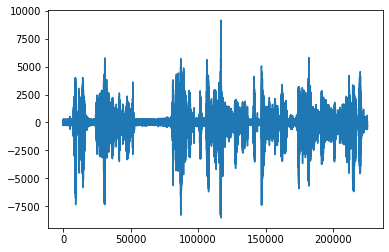

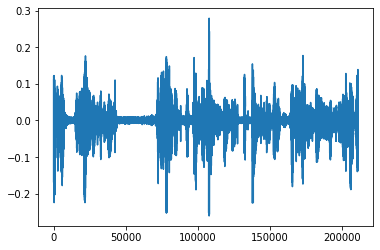

(211171,)


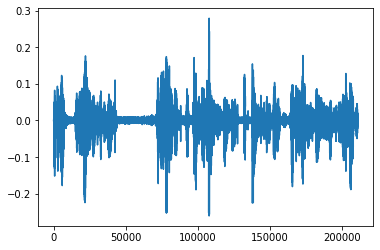

(825, 257)


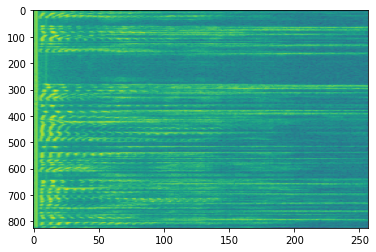

(825, 128)


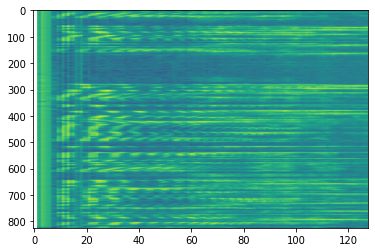

In [15]:
# Read the Audio Tensor from file
file_path = file_names[0]
audio_tensor = tfio.audio.AudioIOTensor(file_path).to_tensor()

# Plot raw audio signal
plt.figure()
plt.plot(audio_tensor.numpy())

# cast to floating
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
print(tensor.shape)
tensor = tensor[:, 0]

# Trim the noise (begin and end)
position = tfio.experimental.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)
start, stop = position[0], position[1]
print(start, stop)

processed = tensor[start:stop]

print(processed.shape)
plt.figure()
plt.plot(processed.numpy())
plt.show()


# Fade in and out
fade = tfio.experimental.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

print(fade.shape)
plt.figure()
plt.plot(fade.numpy())
plt.show()

# Spectogram
spectogram = tfio.experimental.audio.spectrogram(
      fade, nfft=512, window=512, stride=256)

print(spectogram.shape)
plt.figure()
plt.imshow(tf.math.log(spectogram).numpy(), aspect="auto")
plt.show()

# Mel spectrogram
mel_spectrogram = tfio.experimental.audio.melscale(
    spectogram, rate=16000, mels=128, fmin=0, fmax=8000)

print(mel_spectrogram.shape)
plt.figure()
data = tf.math.log(mel_spectrogram).numpy()
plt.imshow(data, aspect="auto")
plt.show()

## Process files

In [17]:
def load_audio(file_path):
    """Load and decode flac files"""
    audio = tf.io.read_file(file_path)
    audio = tfio.audio.decode_flac(audio, dtype=tf.int16) #TODO: check datatype
    return audio

def build_file_dataset(file_paths):
    """Create a DataSet object containing all file paths"""
    file_paths = tf.convert_to_tensor(file_paths, dtype=tf.string)
    dataset = tf.data.Dataset.list_files(file_paths).prefetch(1)
    return dataset

def transform_files(files, process_fn):
    """Apply processing step to dataset"""
    files = files.map(process_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return files

def process_files(file_path):
  """Load audio file from disk and perform processing step to get mel spectorgram"""
  audio_tensor = load_audio(file_path)

  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0 # cause we have int16 data  2**15 = 32768.0
  tensor = tensor[:, 0]

  spectogram = tfio.experimental.audio.spectrogram(
      tensor, nfft=512, window=512, stride=256
  )
  mel_spectogram = tfio.experimental.audio.melscale(
      spectogram, rate=16000, mels=128, fmin=0, fmax=8000
  )

  return mel_spectogram

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get all flac filenames
%time file_names = get_all_files(path, max_files=1000)

# Create a dataset that contains all the file names
%time file_data_set = build_file_dataset(file_names)

# apply transformation
%time processed_files = transform_files(file_data_set, process_files)


CPU times: user 45 ms, sys: 21.4 ms, total: 66.5 ms
Wall time: 6.63 s
CPU times: user 101 ms, sys: 111 ms, total: 212 ms
Wall time: 896 ms
CPU times: user 603 ms, sys: 22.6 ms, total: 626 ms
Wall time: 659 ms


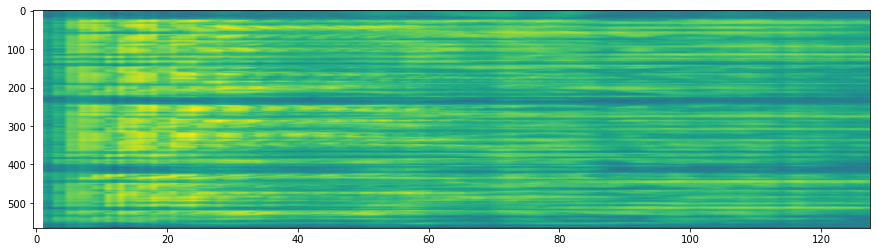

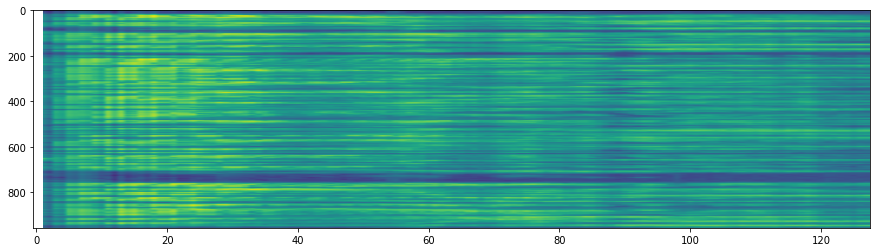

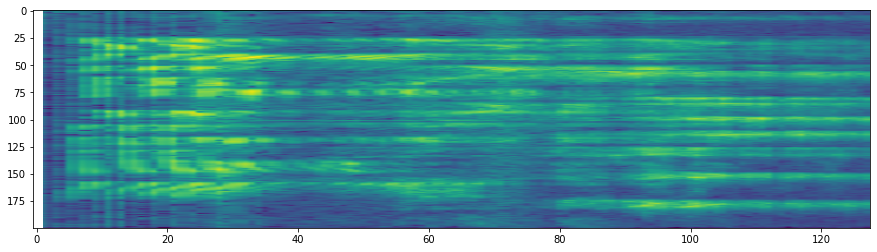

In [19]:
for i in processed_files.take(3):
  plt.figure(figsize=(15,4))
  data = tf.math.log(i).numpy()
  plt.imshow(data, aspect="auto")
  plt.show()

## Write files to disk

Use to convert tensors to binary string:
```
tf.io.serialize_tensor(tensor, name=None)
```
And to convert them back use:
```
tf.io.parse_tensor(serialized, out_type, name=None)
```




In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant.
def spectrogram_example(spectrogram_string):
  serialized_tensor = tf.io.serialize_tensor(spectrogram_string)
  feature = {
      # 'label': _int64_feature(label),  # For now don't include label
      'mel_spectrogram': _bytes_feature(serialized_tensor),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [21]:
# Write the spectrogram files to `images.tfrecords`.
# First, process the spectrograms into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'DataSet/dataset.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for processed_file in processed_files:
    tf_example = spectrogram_example(processed_file)
    writer.write(tf_example.SerializeToString())

In [31]:
# check the size of the tfrecord file
!du -sh {record_file}

365M	DataSet/dataset.tfrecords


## Read TFRecord from disk


In [22]:
tfrecord_path = "DataSet/dataset.tfrecords"

In [23]:
processed_dataset = tf.data.TFRecordDataset(tfrecord_path)

In [25]:
# Create a dictionary describing the features.
feature_description = {
    # 'label': tf.io.FixedLenFeature([], tf.int64),
    'mel_spectrogram': tf.io.RaggedFeature(tf.string),
}

def _parse_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _parse_spectrograms(example):
  """Convert the serialized tensor back to a tensor."""
  example["mel_spectrogram"] = tf.io.parse_tensor(example["mel_spectrogram"], out_type=tf.float32)
  return example

In [26]:
parsed_dataset = processed_dataset.map(_parse_function) #.map(_parse_spectrograms) #.batch(10).prefetch(1)

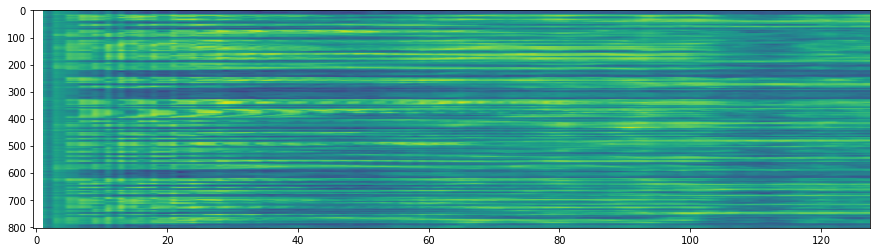

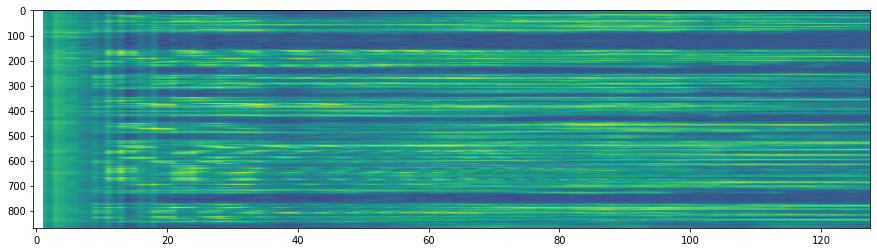

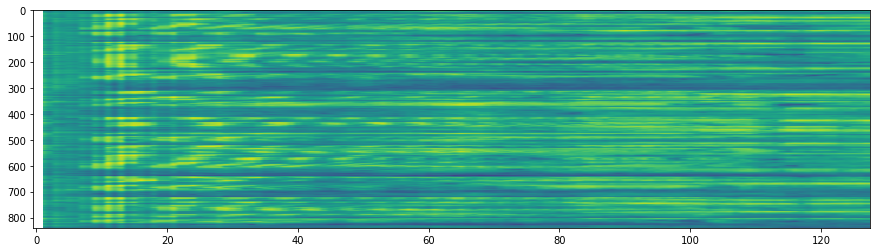

In [27]:
for i in parsed_dataset.take(3): 
  tensor = tf.io.parse_tensor(i["mel_spectrogram"].numpy()[0], out_type=tf.float32)
  plt.figure(figsize=(15,4))
  data = tf.math.log(tensor).numpy()
  plt.imshow(data, aspect="auto")
  plt.show()

In [28]:
parsed_dataset.element_spec

{'mel_spectrogram': TensorSpec(shape=(None,), dtype=tf.string, name=None)}